# Drift Simulator

In [1]:
from datetime import timedelta
import numpy as np

In [2]:
drift_model = 'turnbull'  # options are 'turnbull' or 'wagner'
ocean_model = 'ecmwf'  # options are 'ecmwf'
atm_model = 'ecmwf'  # options are 'ecmwf'

In [3]:
import os, sys, inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

In [4]:
if drift_model == 'turnbull':
    from icedef.turnbull import drift
elif drift_model == 'wagner':
    from iceberg.wagner import drift
else:
    print('drift model specified is invalid')
    
from icedef import iceberg, metocean, plot

## Iceberg Data

In [5]:
# If iip_iceberg is set to True then the user must choose an iceberg from the 2015 iip
# iceberg sightings database
iip_iceberg = True

if iip_iceberg:
    #iceberg_ID = 20668
    #iip_berg_df = iip_df.loc[iip_df['ICEBERG_NUMBER'] == iceberg_ID]
    iip_df = iceberg.get_iip_df(2015)
    iip_df = iceberg.add_datetime_column(iip_df)
    iip_berg_df = iip_df.loc[iip_df.index[3283:3286]].reset_index()
    iip_berg_df
    ID = iip_berg_df['ICEBERG_NUMBER'].loc[0]
    T = iip_berg_df['TIMESTAMP'].dt.to_pydatetime()[0]
    X = iip_berg_df['SIGHTING_LONGITUDE'].loc[0]
    Y = iip_berg_df['SIGHTING_LATITUDE'].loc[0]
    Vx = 0
    Vy = 0
    size = iip_berg_df['SIZE'].loc[0]
    shape = iip_berg_df['SHAPE'].loc[0]
    iip_berg = iceberg.Iceberg(ID, T, X, Y, Vx, Vy, size, shape)
    iip_berg.history['T'] = iip_berg_df['TIMESTAMP'].dt.to_pydatetime()
    iip_berg.history['X'] = iip_berg_df['SIGHTING_LONGITUDE'].loc[:].tolist()
    iip_berg.history['Y'] = iip_berg_df['SIGHTING_LATITUDE'].loc[:].tolist()
    
    mod_berg = iceberg.Iceberg(ID, T, X, Y, Vx, Vy, size, shape)

else:
    print("Under Construction")

/home/evankielley/IceDEF/icedef/iceberg.py:204: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  iip_df['TIMESTAMP'] += pd.to_timedelta(pd.to_datetime(iip_df['SIGHTING_TIME'], format='%H%M').dt.hour, unit='h')
/home/evankielley/IceDEF/icedef/iceberg.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  iip_df['TIMESTAMP'] += pd.to_timedelta(pd.to_datetime(iip_df['SIGHTING_TIME'], format='%H%M').dt.minute, unit='m')


## Metocean Data

In [6]:
ocean_data = metocean.ECMWF_Ocean(min(iip_berg.history['X']), max(iip_berg.history['X']),
                         min(iip_berg.history['Y']), max(iip_berg.history['Y']),
                         iip_berg.history['T'][0], iip_berg.history['T'][-1])

ocean_data.filenames

['ftp://data.munroelab.ca/pub/ECMWF/ocean/daily/20150616.nc',
 'ftp://data.munroelab.ca/pub/ECMWF/ocean/daily/20150617.nc',
 'ftp://data.munroelab.ca/pub/ECMWF/ocean/daily/20150618.nc']

In [7]:
atm_data = metocean.ECMWF_Atm(min(iip_berg.history['X']), max(iip_berg.history['X']),
                         min(iip_berg.history['Y']), max(iip_berg.history['Y']),
                         iip_berg.history['T'][0], iip_berg.history['T'][-1])

atm_data.filenames

['ftp://data.munroelab.ca/pub/ECMWF/atm/daily/sub20150616.nc',
 'ftp://data.munroelab.ca/pub/ECMWF/atm/daily/sub20150617.nc',
 'ftp://data.munroelab.ca/pub/ECMWF/atm/daily/sub20150618.nc']

## Timesteps

In [8]:
t0 = iip_berg.history['T'][0]
tf = iip_berg.history['T'][-1]
t_delta = tf - t0
t_delta_hours = t_delta.days*24 + t_delta.seconds/3600
t_step_hours = 0.1
t_step = timedelta(hours = t_step_hours)
dt = t_step_hours*3600  # timestep in seconds
t_all = []

for i in np.arange(0, t_delta_hours + t_step_hours, t_step_hours):
    new_date = t0 + timedelta(hours=i)
    t_all.append(new_date)

## Drifting

In [9]:
earth_radius = 6378*1e3  # radius of Earth  (m)


# Buffer number for bounding spatial box
drift_xmin = max(min(ocean_data.lons), min(atm_data.lons))
drift_xmax = min(max(ocean_data.lons), max(atm_data.lons))
drift_ymin = max(min(ocean_data.lats), min(atm_data.lats))
drift_ymax = min(max(ocean_data.lats), max(atm_data.lats))


for t in t_all:

    mod_berg.T = t

    if drift_model == 'turnbull':
    
        ax, ay = drift(mod_berg, ocean_data, atm_data) 

        mod_berg.Vx += dt*ax  
        mod_berg.Vy += dt*ay

    elif drift_model == 'wagner':
    
        mod_berg.Vx, mod_berg.Vy = drift(mod_berg, ocean_data, atm_data) 

    
    # Iceberg position (note the conversion from meters back to degrees)
    y_ = mod_berg.Y
    mod_berg.Y += dt*mod_berg.Vy*(180/(np.pi*earth_radius))  # y-component of iceberg position (degrees latitude)
    mod_berg.X += dt*mod_berg.Vx/(np.cos((((y_ + mod_berg.Y)/2)*np.pi)/180))*(180/(np.pi*earth_radius))  # x-component of iceberg position (degrees longitude)

    if mod_berg.X > drift_xmax:
        print('Iceberg out-of-bounds')
        break

    elif mod_berg.X < drift_xmin: 
        print('Iceberg out-of-bounds')
        break

    elif mod_berg.Y > drift_ymax:
        print('Iceberg out-of-bounds')
        break

    elif mod_berg.Y < drift_ymin:
        print('Iceberg out-of-bounds')
        break


    else:
        mod_berg.history['T'].append(mod_berg.T)
        mod_berg.history['X'].append(mod_berg.X)
        mod_berg.history['Y'].append(mod_berg.Y)
        mod_berg.history['Vx'].append(mod_berg.Vx)
        mod_berg.history['Vy'].append(mod_berg.Vy)

print("Final time: {}".format(t)) 

Final time: 2015-06-18 12:52:00


## Plotting

/home/evankielley/.conda/envs/icedef/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/home/evankielley/.conda/envs/icedef/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


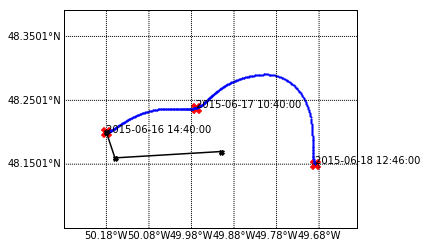

In [10]:
plot.plot_drift_track_test_case(iip_berg, mod_berg)